In [ ]:
!pip install vizdoom
!cd github/ & git clone https://github.com/mwydmuch/ViZdoom

In [1]:
from vizdoom import *
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
from gym import Env
from gym.spaces import Discrete, Box
import cv2
from stable_baselines3.common import env_checker

# Random Agent

In [18]:
game = DoomGame()
game.load_config("github/ViZdoom/scenarios/defend_the_center.cfg")
game.init()

In [19]:
episodes = 10
actions = np.eye(3,dtype=np.uint8)

for episode in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        random_action = random.choice(actions)
        reward = game.make_action(random_action)
        time.sleep(0.02)
    print("Result :", game.get_total_reward())
    time.sleep(2)
game.close()


Result : -1.0
Result : 0.0
Result : 0.0
Result : 0.0
Result : -1.0
Result : 0.0
Result : 0.0
Result : 2.0
Result : -1.0
Result : 0.0


# Wrapping Doom Game into a Gym Environment

In [2]:
class VizDoomGym(Env):
    def __init__(self,render=False):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config("github/ViZdoom/scenarios/defend_the_center.cfg")
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        self.game.init()
        self.observation_space = Box(low=0, high=255, shape=(85,160,1), dtype=np.uint8) 

        self.action_space = Discrete(3)
        
    def step(self,action):
        actions = np.eye(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action],4)
        
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            info = self.game.get_state().game_variables[0]
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {"info":info}
        done = self.game.is_episode_finished()
        return state, reward, done, info
    
    def render():
        pass
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        state = self.grayscale(state)
        return state
    
    def grayscale(self,observation):
        """Grayscale, trim the bottom infos and reduce the number of pixels"""
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        state = state[:85, :]
        return state
    
    def close(self):
        self.game.close()

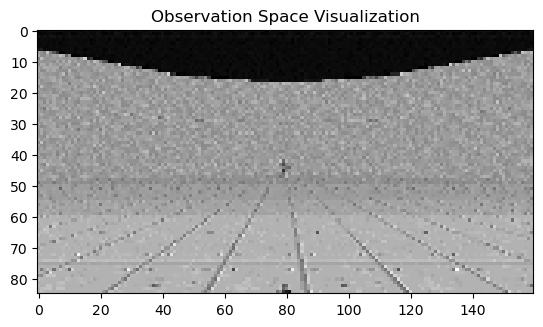

In [102]:
env = VizDoomGym(render=True)
state = env.reset()
plt.imshow(state,cmap="gray")
plt.title("Observation Space Visualization")
plt.show()
env.close()

# Train the model

In [3]:
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [104]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [105]:
CHECKPOINT_DIR = './train/train_defend_center'
LOG_DIR = './logs/log_defend_center'

In [106]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [ ]:
env = VizDoomGym()

In [ ]:
# model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)
model = PPO.load('./train/train_defend_center/best_model_160000',env, learning_rate = 0.00001)

In [ ]:
model.learn(total_timesteps=100000, callback=callback, reset_num_timesteps = False)

# Test the model

In [4]:
model = PPO.load('./train/train_defend_center/best_model_160000.zip') # The model I trained with the best results

In [7]:
env = VizDoomGym(render=True)

In [128]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
"Mean reward : " + str(mean_reward)

'Mean reward : 11.4'

In [9]:
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.30)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode,total_reward))
    time.sleep(1)
env.close()

Total Reward for episode 8.0 is 0
Total Reward for episode 9.0 is 1
Total Reward for episode 10.0 is 2
Total Reward for episode 13.0 is 3
Total Reward for episode 10.0 is 4
Total Reward for episode 11.0 is 5
Total Reward for episode 9.0 is 6
Total Reward for episode 7.0 is 7
Total Reward for episode 13.0 is 8
Total Reward for episode 11.0 is 9
